In [1]:
# https://stackoverflow.com/a/47311878/1164295

%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
import pandas
from matplotlib import pyplot as plt
import matplotlib
import seaborn
import numpy as np
import sys

In [4]:
sys.version_info

sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)

In [5]:
print("matplotlib", matplotlib.__version__)
print("seaborn", seaborn.__version__)
print("pandas", pandas.__version__)
print("numpy", np.__version__)

matplotlib 3.6.2
seaborn 0.12.2
pandas 1.5.2
numpy 1.23.5


In [6]:
x = 4
number_of_iterations = 10

Given a functional relation 

                           +--------------------------------+
                          c|                                |
               +----+      |     +-----+         +-----+ c  |
    x -------->|    |      +---->|     |         |     +----+
               | A  |  a         | B   |   b     | C   |       d
       b +---->|    +----------->|     +->-+---->|     +------------>
         ^     +----+            +-----+   |     +-----+
         |              b                  |
         +--------<------------------------+

What is the value of `d` as a function of `x`?

Graph created using https://asciiflow.com/#/

In [7]:
# all parameters must be declared
# membership in clusters must be declared
parameter_clusters = {'cat3': ['b', 'x'], 
                      'cat4': ['c'],
                      'not part of a cluster': ['a', 'd']}

In [8]:
def A(b: int, x: int) -> int:
    """
    cluster: cat1
    
    description of scope
    """
    a = b + x
    return a

In [9]:
def B(c: int, a: int) -> int:
    """
    cluster: cat2
    """
    b = a + c
    return b

In [10]:
def C(b: int):
    """
    cluster: cat1
    """
    c = b+1
    d = b+2
    return c,d

In [11]:
results = []

b_list = [1,2,3]
for initial_b in b_list:
    b = initial_b

    c_list = [2,3,4,5,6]
    for initial_c in c_list:
        c = initial_c

        for iteration_index in range(number_of_iterations):
            a = A(x, b)
            b = B(c, a)
            c, d = C(b)
            this_loop_dict = {'index': iteration_index,
                              '$b_{initial}$': initial_b,
                              '$c_{initial}$': initial_c,
                              'a': a,
                              'b': b,
                              'c': c,
                              'd': d}
            results.append(this_loop_dict)

In [12]:
df = pandas.DataFrame(results)

In [13]:
# https://www.python-graph-gallery.com/90-heatmaps-with-various-input-format

df_wide = df.pivot_table( index='index', columns='$c_{initial}$', values='d')

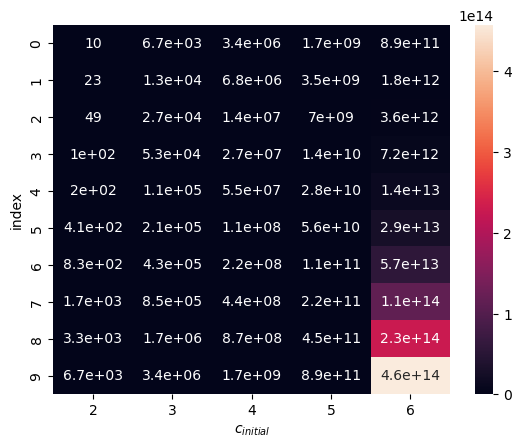

In [14]:
# https://seaborn.pydata.org/examples/spreadsheet_heatmap.html

seaborn.heatmap(df_wide, annot=True);

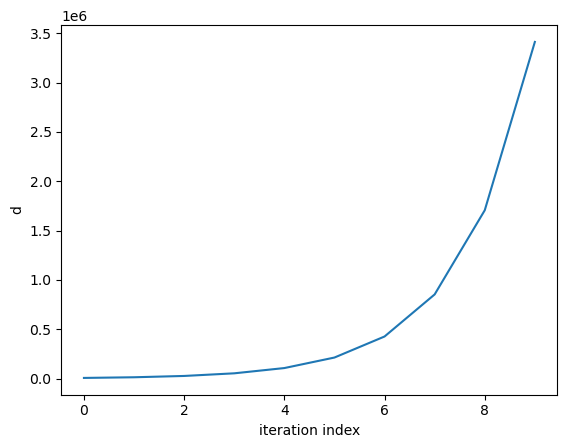

In [15]:
initial_c = 3
plt.plot(df_wide[initial_c]);
plt.xlabel('iteration index')
plt.ylabel('d');

In [16]:
df_wide.shape

(10, 5)

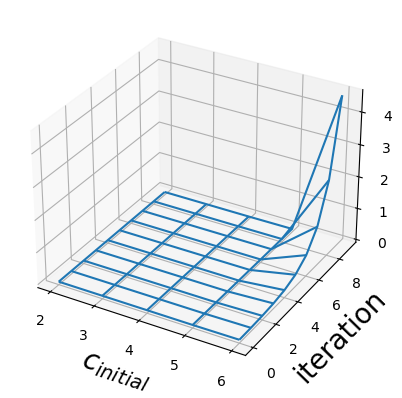

In [17]:
axes = plt.axes(projection='3d')

col, ind = np.meshgrid(df_wide.columns, df_wide.index)

axes.plot_wireframe(col, ind, df_wide)
plt.gca().set_xlabel('$c_{initial}$', fontsize=20)
plt.gca().set_ylabel('iteration', fontsize=20)
plt.gca().set_zlabel('d', fontsize=20);
plt.show()

# introspection to create graph

## using pycallgraph (dynamic)

## using AST (static)

https://docs.python.org/3/library/ast.html

### first extract the Python functions from .ipynb

In [18]:
import json
import ast

In [19]:
with open("three_functions_two_loops.ipynb", "r") as file_handle:
    content = json.load(file_handle)

In [20]:
def extract_functions(module_ast):
    list_of_functions = []
    for node in module_ast.body:
        if isinstance(node, ast.FunctionDef):
            #print("function name =",node.name) # module_ast.body[0].name
            this_func = {'module ast': module_ast,
                         'function name': node.name,
                         'input arguments': [],
                         'output names': []}
            for arg_node in node.args.args:
                #print("input argument name =",arg_node.arg) # module_ast.body[0].args.args[0].arg
                this_func['input arguments'].append(arg_node.arg)
            for bod_node in node.body:
                if isinstance(bod_node, ast.Expr): 
                    if isinstance(bod_node.value, ast.Constant):
                        #print("comment is",bod_node.value.value.strip())
                        docstring_as_list = bod_node.value.value.split("\n")
                        for this_line in docstring_as_list:
                            if "cluster: " in this_line:
                                this_func['cluster'] = this_line.strip().replace("cluster: ","")
                if isinstance(bod_node, ast.Return):
                    if isinstance(bod_node.value, ast.Name): # single return
                        #print("output name =",bod_node.value.id) # module_ast.body[0].body[3].value.id
                        this_func['output names'].append(bod_node.value.id)
                    elif isinstance(bod_node.value, ast.Tuple): # multiple returns
                        for this_arg_node in bod_node.value.elts:
                            #print("output name =",this_arg_node.id) # module_ast.body[0].body[3].value.elts[0].id
                            this_func['output names'].append(this_arg_node.id)
    list_of_functions.append(this_func)
    return list_of_functions

In [21]:
list_of_functions = []

for cell in content['cells']:
    if 'source' in cell.keys():
        source_code = "".join(cell['source'])
        list_of_functions_this_cell = []
        if source_code.startswith("def "):
            module_ast = ast.parse(source_code)
            # in case the "extract_functions" fails, to troubleshoot 
            show_ast = ast.dump(module_ast, indent=4)
            list_of_functions_this_cell = extract_functions(module_ast)
        for cell_func in list_of_functions_this_cell:
            list_of_functions.append(cell_func)

### convert to graphviz

https://pypi.org/project/graphviz/

https://pygraphviz.github.io/

https://h1ros.github.io/posts/introduction-to-graphviz-in-jupyter-notebook/

In [22]:
import graphviz # https://github.com/xflr6/graphviz

In [23]:
cluster_and_nodes = {"not part of a cluster": []}

# Create Digraph object
functional_relations = graphviz.Digraph(graph_attr={'rankdir':'LR'})

# pass 1: extract the clusters
for this_func_dict in list_of_functions:
    #print(this_func_dict)
    if this_func_dict['function name']=='extract_functions':
        continue # https://docs.python.org/3/tutorial/controlflow.html

    if 'cluster' in this_func_dict.keys():
        if this_func_dict['cluster'] not in cluster_and_nodes.keys():
            cluster_and_nodes[this_func_dict['cluster']] = [this_func_dict]
        else:
            cluster_and_nodes[this_func_dict['cluster']].append(this_func_dict)
    else: # not part of a cluster
        cluster_and_nodes["not part of a cluster"].append(this_func_dict)


# https://graphviz.readthedocs.io/en/stable/manual.html#subgraphs-clusters
# parameters
for param_cluster_name, list_of_parameters in parameter_clusters.items():
    if param_cluster_name == 'not part of a cluster':
        for param in list_of_parameters:
            functional_relations.node(param)
            #print(param,"is not part of a cluster")
    else:
        c = graphviz.Digraph(name="cluster_"+param_cluster_name.replace(" ","_"))
        
        c.attr(label=param_cluster_name)
        for param in list_of_parameters:
            c.node(param)
            #print(param,"is part of", param_cluster_name)
        functional_relations.subgraph(c)
            
# functions
for cluster_name, list_of_function_dicts in cluster_and_nodes.items():
    if cluster_name=="not part of a cluster":
        for this_func_dict in list_of_function_dicts:
            functional_relations.node(this_func_dict['function name'], 
                                      shape="rect")

    else: # cluster
        c = graphviz.Digraph(name="cluster_"+cluster_name.replace(" ","_"))
        c.attr(label=cluster_name)
        for this_func_dict in list_of_function_dicts:
            c.node(this_func_dict['function name'], 
                                  shape="rect")

        functional_relations.subgraph(c)
    
    
# edges are never within clusters
for this_func_dict in list_of_functions:
    if this_func_dict['function name']=='extract_functions':
        continue # https://docs.python.org/3/tutorial/controlflow.html
        
    for input_arg in this_func_dict['input arguments']:
        #functional_relations.node(input_arg)
        functional_relations.edge(input_arg,this_func_dict['function name'])
    for output_arg in this_func_dict['output names']:
        functional_relations.edge(this_func_dict['function name'], output_arg)



In [24]:
print(functional_relations.source)

digraph {
	graph [rankdir=LR]
	subgraph cluster_cat3 {
		label=cat3
		b
		x
	}
	subgraph cluster_cat4 {
		label=cat4
		c
	}
	a
	d
	subgraph cluster_cat1 {
		label=cat1
		A [shape=rect]
		C [shape=rect]
	}
	subgraph cluster_cat2 {
		label=cat2
		B [shape=rect]
	}
	b -> A
	x -> A
	A -> a
	c -> B
	a -> B
	B -> b
	b -> C
	C -> c
	C -> d
}



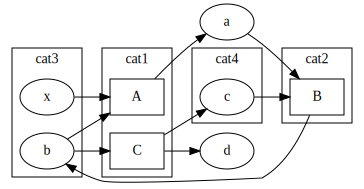

In [25]:
# inline visualization

functional_relations

In [26]:
functional_relations.format = 'png'

In [27]:
functional_relations.view(filename='relations')

'relations.png'

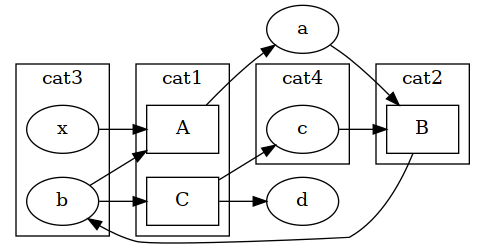

In [28]:
from IPython.display import Image
Image('relations.png')